In [5]:
# %load C:\Researches\Data\MPS3\202103_2\tryFit_5.py
# %%
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy import optimize
from scipy import signal
from scipy.signal.signaltools import choose_conv_method
import os
import csv

%matplotlib widget
plt.rcParams["figure.figsize"] = (8.0, 6.0)

from cycler import cycler

custom_cycler = cycler(
    color=["#0072BD", "#D95319", "#EDB120", "#7E2F8E", "#77AC30", "#4DBEEE", "#A2142F"]
)
plt.rc("axes", prop_cycle=custom_cycler)

# %%
baseAtom = "Fe"
refEnergy = 576  # eV
energyDispersion = 0.0078  # eV
myPath = r"C:\Researches\Data\MPS3\TMPC_YT"
refElasticPixel = 5600

# %%
def MakeFileName(scanNumber):
    global baseAtom
    if scanNumber < 10:
        fileName = baseAtom + "_" + "000" + str(scanNumber)
    elif scanNumber < 100:
        fileName = baseAtom + "_" + "00" + str(scanNumber)
    elif scanNumber < 1000:
        fileName = baseAtom + "_" + "0" + str(scanNumber)
    else:
        fileName = baseAtom + "_" + str(scanNumber)
    return fileName


def xCorrElastic(uncorrData):
    global refElasticPixel
    peaks, _ = signal.find_peaks(
        uncorrData[1, :], height=np.max(uncorrData[1, :]) / 20, width=3
    )
    uncorrData[1, :] = np.roll(uncorrData[1, :], refElasticPixel - peaks[-1])
    popt, pcov = optimize.curve_fit(
        gaussian_norm,
        uncorrData[0, :],
        uncorrData[1, :],
        p0=[refElasticPixel * energyDispersion, 0.3, np.max(uncorrData)],
    )
    corrData = np.array([popt[0] - uncorrData[0, :], uncorrData[1, :]])
    return corrData


def xCorr(refData, uncorrData):
    corr = signal.correlate(refData, uncorrData)  # consider full pattern
    lags = signal.correlation_lags(len(refData), len(uncorrData))
    lag = lags[np.argmax(corr)]

    # elastic corr
    uncorrData = np.roll(uncorrData, lag)
    peaks, _ = signal.find_peaks(refData, height=np.max(refData) / 20, width=3)
    corr = signal.correlate(
        refData[peaks[-1] - 50 : peaks[-1] + 50],
        uncorrData[peaks[-1] - 50 : peaks[-1] + 50],
    )
    lags = signal.correlation_lags(
        len(refData[peaks[-1] - 50 : peaks[-1] + 50]),
        len(uncorrData[peaks[-1] - 50 : peaks[-1] + 50]),
    )
    lag = lags[np.argmax(corr)]

    corrData = np.roll(uncorrData, lag)
    return corrData


def EnergyTrans(pixelData):
    global energyDispersion
    xData = np.arange(len(pixelData))
    energyData = xCorrElastic(np.array([xData * energyDispersion, pixelData]))
    return energyData


def xCorrFull(refData, uncorrData):
    corr = signal.correlate(refData, uncorrData)
    lags = signal.correlation_lags(len(refData), len(uncorrData))
    lag = lags[np.argmax(corr)]
    corrData = np.roll(uncorrData, lag)
    return corrData


def GetData(scanNumber):
    global myPath
    f1 = h5py.File(myPath + "\\RIXS\\" + MakeFileName(scanNumber) + "_d1.h5", "r")
    f2 = h5py.File(myPath + "\\RIXS\\" + MakeFileName(scanNumber) + "_d2.h5", "r")
    f3 = h5py.File(myPath + "\\RIXS\\" + MakeFileName(scanNumber) + "_d3.h5", "r")
    ccd1 = f1["entry"]["analysis"]["spectrum"][()]
    ccd2 = f2["entry"]["analysis"]["spectrum"][()]
    ccd3 = f3["entry"]["analysis"]["spectrum"][()]
    acqTime1 = np.mean(f1["entry"]["instrument"]["NDAttributes"]["AcquireTime"][()])
    acqTime2 = np.mean(f1["entry"]["instrument"]["NDAttributes"]["AcquireTime"][()])
    acqTime3 = np.mean(f1["entry"]["instrument"]["NDAttributes"]["AcquireTime"][()])
    ccd = (xCorr(ccd2, ccd1) + ccd2 + xCorr(ccd2, ccd3)) / 3
    acqTime = (acqTime1 + acqTime2 + acqTime3) / 3
    return ccd, acqTime


def CombineData(scans):
    refData, totalTime = GetData(scans[0])
    data = refData
    for x in scans[1:]:
        tempData, oneTime = GetData(x)
        data = data + xCorr(refData, tempData)
        totalTime = totalTime + oneTime
    pixelData = data / totalTime * 300  # normalize to 5 minutes
    energyData = EnergyTrans(pixelData)
    return energyData





C:\Users\wei_y1\AppData\Local\Temp\ipykernel_1972\4086354820.py:8: DeprecationWarning: Please use `choose_conv_method` from the `scipy.signal` namespace, the `scipy.signal.signaltools` namespace is deprecated.
  from scipy.signal.signaltools import choose_conv_method


In [6]:
# %%
def gaussian_norm(x, xc, fwhm, area):
    norm = 1.0 / fwhm / np.sqrt(np.pi / 4 / np.log(2))
    return area * norm * np.exp(-4 * np.log(2) * (x - xc) ** 2 / fwhm ** 2)

def gaussian_amp(x, xc, fwhm, amp):
    return amp * np.exp(-4 * np.log(2) * (x - xc) ** 2 / fwhm ** 2)


def lorentzian_norm(x, mu, gamma, amp):
    return amp / np.pi * gamma / 2 / ((x - mu) ** 2 + (gamma / 2) ** 2)


def PsdVoigt(x, xc, area, w, mu):
    return area * (
        mu * 2 / np.pi * w / (4 * (x - xc) ** 2 + w ** 2)
        + (1 - mu)
        * np.sqrt(4 * np.log(2.0))
        / np.sqrt(np.pi)
        / w
        * np.exp(-4 * np.log(2.0) * (x - xc) ** 2 / w ** 2)
    )


# %%
def threeLorentz(x, y0, mu1, gamma1, amp1, mu2, gamma2, amp2, mu3, gamma3, amp3):
    return (
        y0
        + lorentzian_norm(x, mu1, gamma1, amp1)
        + lorentzian_norm(x, mu2, gamma2, amp2)
        + lorentzian_norm(x, mu3, gamma3, amp3)
    )


def threeGaussian(x, y0, gamma, mu, amp, mu1, amp1, mu2, amp2):
    return (
        y0
        + gaussian_norm(x, mu, gamma, amp)
        + gaussian_norm(x, mu1, gamma, amp1)
        + gaussian_norm(x, mu2, gamma, amp2)
    )


def fitPeaks(xdata, ydata, param_p0, param_bounds):
    popt, pcov = optimize.curve_fit(
        threeGaussian, xdata, ydata, p0=param_p0, bounds=param_bounds
    )
    return popt


def fixLines(scans):

    energyData = CombineData(scans)

    X = energyData[0, (refElasticPixel - 100) : (refElasticPixel + 100)]
    Y = energyData[1, (refElasticPixel - 100) : (refElasticPixel + 100)]

    param_p0 = [0, 0.08, -0.16, 99, -0.07, 138, 0.054, 141]
    param_down = [0, -0.01, -0.1, -99, -0.1, -138, -0.1, -141]
    param_up = [10, 0.01, 0.1, np.inf, 0.1, np.inf, 0.1, np.inf]
    param_bounds = (
        np.array(param_p0) + np.array(param_down),
        np.array(param_p0) + np.array(param_up),
    )

    popt = fitPeaks(X, Y, param_p0, param_bounds)
    # print(popt)
    energyData[0, :] = energyData[0, :] - popt[2]
    energyData[0, :] = energyData[0,::-1]
    energyData[1, :] = energyData[1,::-1]
#     plt.plot(energyData[0, :], energyData[1, :],label=key)

#     f = open(myPath + "\\Analysis\\" + key + ".dat", "w")
#     np.savetxt(f, energyData.T, delimiter="\t")
#     f.close()

    return energyData

# %%

In [7]:
# %%
def multiPV(
    x,
    y0,
    mu,
    xc,
    area,
    w,
    xc1,
    area1,
    w1,
    xc2,
    area2,
    w2,
    xc3,
    area3,
    w3,
    xc4,
    area4,
    w4,
):
    return (
        y0
        + PsdVoigt(x, xc, area, w, mu)
        + PsdVoigt(x, xc1, area1, w1, mu)
        + PsdVoigt(x, xc2, area2, w2, mu)
        + PsdVoigt(x, xc3, area3, w3, mu)
        + PsdVoigt(x, xc4, area4, w4, mu)
    )

def twoGauss(x,y0,a, mu, gamma, amp,mu1, gamma1, amp1):
    return (y0+a*x+gaussian_amp(x, mu, gamma, amp)+gaussian_amp(x, mu1, gamma1, amp1))


def fitmultiPeaks(xdata, ydata, param_p0, param_bounds):
    popt, pcov = optimize.curve_fit(
        twoGauss, xdata, ydata, p0=param_p0, bounds=param_bounds
    )
    return popt


def twoPeaks(xdata, ydata, param_p0, param_bounds):
    popt, pcov = optimize.curve_fit(
        multiPV, xdata, ydata, p0=param_p0, bounds=param_bounds
    )
    return popt


def fitLines(energyData):
    Xall = energyData[0, :]
    Yall = energyData[1, :]
    X = Xall[((Xall>0.5) & (Xall<1.7))]
    Y = Yall[((Xall>0.5) & (Xall<1.7))]

    # y0,a, mu, gamma, amp,mu1, gamma1, amp1
    param_p0 = [0,0,1.02,0.1,122,1.37,0.16,61]
    param_down = [0,0,1.00,0,0,1.35,0,0]
    param_up = [np.inf,np.inf,1.04,np.inf,np.inf,1.39,np.inf,np.inf]
    param_bounds = (np.array(param_down), np.array(param_up))
    popt = fitmultiPeaks(X, Y, param_p0, param_bounds)

    # plt.figure()
    # plt.plot(X, Y, label=key, linewidth=4)
    # plt.plot(X, twoGauss(X, *popt), "k--")
    # plt.plot(X - popt[2], PsdVoigt(X, popt[2], popt[3], popt[4], popt[1]), "--")
    # plt.plot(X - popt[2], PsdVoigt(X, popt[5], popt[6], popt[7], popt[1]), "--")
    # plt.plot(X - popt[2], PsdVoigt(X, popt[8], popt[9], popt[10], popt[1]), "--")
    # plt.plot(X - popt[2], PsdVoigt(X, popt[11], popt[12], popt[13], popt[1]), "--")
    # plt.plot(X - popt[2], PsdVoigt(X, popt[14], popt[15], popt[16], popt[1]), "--")
    # plt.plot(
    #     X - popt[2],
    #     Y - PsdVoigt(X, popt[2], popt[3], popt[4], popt[1]),
    #     linewidth=4,
    # )
    # plt.xlabel("Energy Loss (eV)")
    # plt.ylabel("Intensity (a.u.)")
    # plt.legend()

    print(key + " : ")
    print(popt)

    # f = open(myPath + "\\Subtract\\" + key + ".dat", "w")
    # np.savetxt(
    #     f,
    #     np.array([X - popt[2], Y - PsdVoigt(X, popt[2], popt[3], popt[4], popt[1])]).T,
    #     delimiter="\t",
    # )
    # f.close()

    return popt

In [3]:
def fixvalue(uncorrData):
    global refElasticPixel
    global energyDispersion
    xData = np.arange(len(uncorrData))
    peaks = xData[uncorrData>50]
    corrData = np.roll(uncorrData, refElasticPixel - peaks[-1])
    energyData = np.array([(xData-refElasticPixel) * -energyDispersion, corrData])
    return energyData

In [1]:
def GetEnergy(scanNumber):
    global myPath
    f1 = h5py.File(myPath + "\\RIXS\\" + MakeFileName(scanNumber) + "_d1.h5", "r")
    Energy = np.mean(f1["entry"]["instrument"]["NDAttributes"]["PhotonEnergy"][()])
    return Energy

In [189]:
from lmfit import Model
from lmfit.models import GaussianModel,VoigtModel

def fit_multi_peaks(X,Y,Range,output = 1):
    x = X[(X>Range[0]) & (X<Range[1])]
    y = Y[(X>Range[0]) & (X<Range[1])]
    # The elastic fit for initial guess:
    P0 = VoigtModel(prefix='P0_')
    pars0 = P0.guess(y, x=x)
    InitialFit = P0.fit(y, pars0, x=x) 
  
    P1 = VoigtModel(prefix='P1_')
    pars = P1.guess(y, x=x)
    pars.update(P1.make_params())
    pars['P1_sigma'].set(min=0,max=0.04)
    pars['P1_center'].set(min=-0.2,max=-0.05)
    
    P2 = VoigtModel(prefix='P2_')
    pars.update(P2.make_params())
    pars['P2_center'].set(min=0.05,max=0.2)
    pars['P2_sigma'].set(min=0,max=0.04)
    
    # P3 = VoigtModel(prefix='P3_')
    # pars.update(P3.make_params())
    # pars['P3_center'].set(value=0.2,min=0.1,max=0.25)
    # pars['P3_sigma'].set(min=0,max=0.1)
    
    mod= P1+P2
    out = mod.fit(y, pars, x=x) 
    comps= out.eval_components(x=x)
    
    if output:
        plt.figure()
        plt.plot(x,y,'.',lw=0.75)
        plt.plot(x,out.best_fit,'-',lw=.75)
        print(out.best_values)
    else:
        return out.best_values

{'P2_amplitude': 31.316775847491954, 'P2_center': 0.19983195018280459, 'P2_sigma': 8.265454169664288e-05, 'P2_gamma': 8.265454169664288e-05, 'P1_amplitude': 57.6400702838485, 'P1_center': -0.05158975315893713, 'P1_sigma': 0.03967342044237865, 'P1_gamma': 0.03967342044237865}


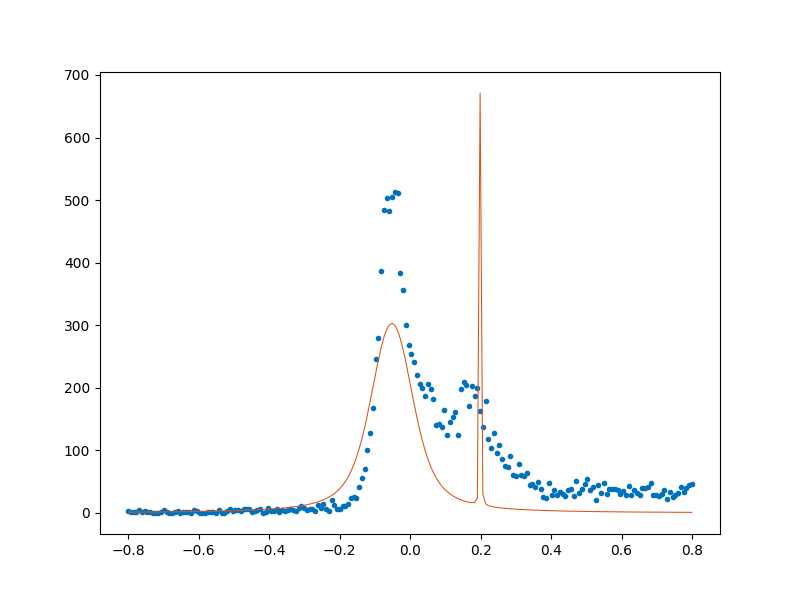

In [190]:
[Eloss,oneData] = CombineData([56])
fitResult=fit_multi_peaks(Eloss,oneData, [-0.8,0.8])

In [24]:
def bin_pixel(data,bin):
    fold_data = np.reshape(data,(int(len(data)/bin),bin))
    bin_data = np.average(fold_data,axis=1)
    return bin_data

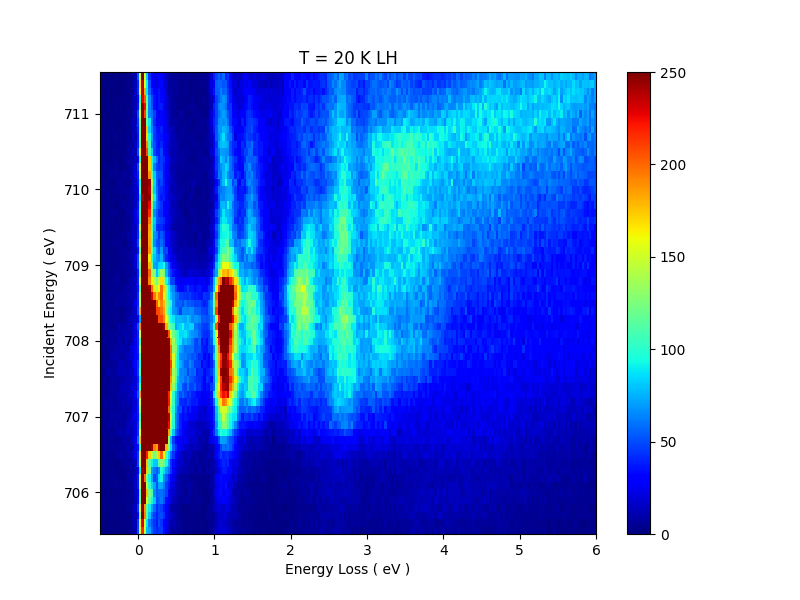

In [42]:
# %%

fig = plt.figure()

scans = [x for x in range(24,85)]

matrixData = np.array([])
matrixEloss = np.array([])
matrixEi = np.array([])

for i,s in enumerate(scans):
    [Eloss,oneData] = CombineData([s])
    ei = GetEnergy(s)
    [Eloss,oneData] = fixvalue(oneData)
    
    Eloss=bin_pixel(Eloss,4)
    oneData = bin_pixel(oneData,4)
    
    # fitResults=fit_multi_peaks(Eloss,oneData, [-1,1],output=0)
    # zeroshift=fitResults['P1_center']/energyDispersion
    # Eloss = Eloss-fitResults['P1_center']
    # oneData = np.roll(oneData,int(np.around(zeroshift)))
    if i == 0:
        matrixData=oneData
        matrixEloss=Eloss
        matrixEi=Eloss-Eloss+ei
    else:
        matrixData=np.vstack((matrixData,oneData))
        matrixEloss=np.vstack((matrixEloss,Eloss))
        matrixEi=np.vstack((matrixEi,Eloss-Eloss+ei))

plt.pcolor(matrixEloss,matrixEi,matrixData,cmap='jet',vmax=250)
plt.xlim([-0.5,6])
plt.ylabel('Incident Energy ( eV )')
plt.xlabel('Energy Loss ( eV )')
plt.title('T = 20 K LH')
plt.colorbar()
plt.savefig('Emap_T20K_LH.eps', dpi=300, format='eps',bbox_inches=None, facecolor=None, edgecolor=None)

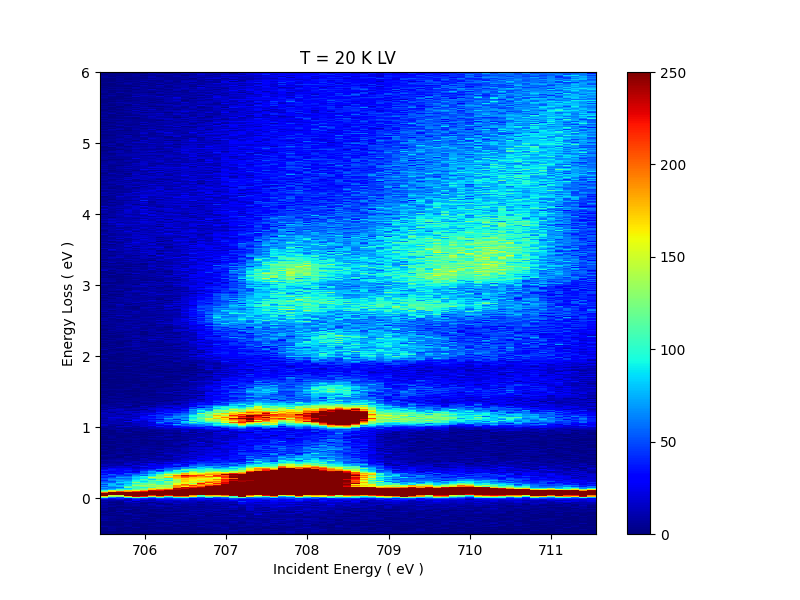

In [41]:
# %%

fig = plt.figure()

scans = [x for x in range(85,146)]

matrixData = np.array([])
matrixEloss = np.array([])
matrixEi = np.array([])

for i,s in enumerate(scans):
    [Eloss,oneData] = CombineData([s])
    [Eloss,oneData] = fixvalue(oneData)
    ei = GetEnergy(s)
    # fitResults=fit_multi_peaks(Eloss,oneData, [-1,1],output=0)
    # zeroshift=fitResults['P1_center']/energyDispersion
    # Eloss = Eloss-fitResults['P1_center']
    # oneData = np.roll(oneData,int(np.around(zeroshift)))
    if i == 0:
        matrixData=oneData
        matrixEloss=Eloss
        matrixEi=Eloss-Eloss+ei
    else:
        matrixData=np.vstack((matrixData,oneData))
        matrixEloss=np.vstack((matrixEloss,Eloss))
        matrixEi=np.vstack((matrixEi,Eloss-Eloss+ei))

plt.pcolor(matrixEi,matrixEloss,matrixData,shading='auto',cmap='jet',vmax=250)
plt.ylim([-0.5,6])
plt.xlabel('Incident Energy ( eV )')
plt.ylabel('Energy Loss ( eV )')
plt.title('T = 20 K LV')
plt.colorbar()
plt.savefig('Emap_T20K_LV.eps', dpi=300, format='eps',bbox_inches=None, facecolor=None, edgecolor=None)


Text(0.5, 1.0, 'T = 200 K LH')

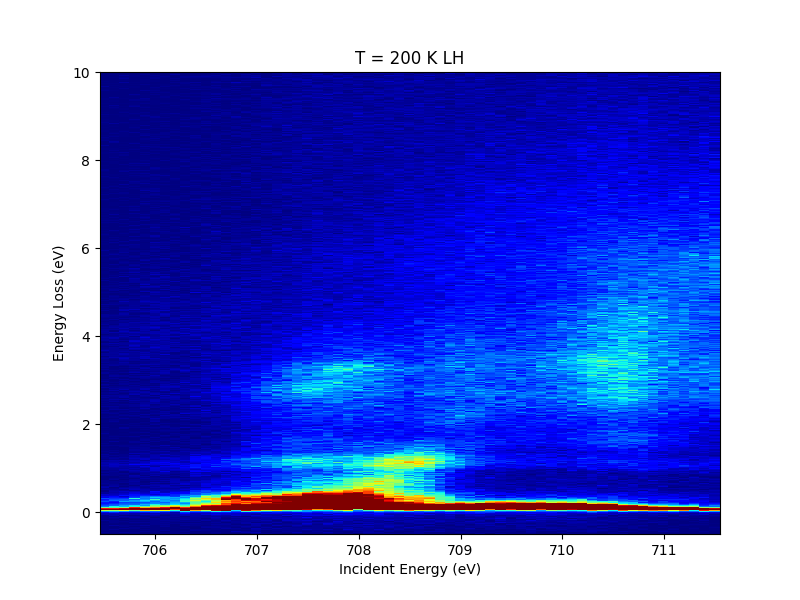

In [10]:
# %%

fig = plt.figure()

scans = [x for x in range(206,267)]

matrixData = np.array([])
matrixEloss = np.array([])
matrixEi = np.array([])

for i,s in enumerate(scans):
    [Eloss,oneData] = CombineData([s])
    [Eloss,oneData] = fixvalue(oneData)
    ei = GetEnergy(s)
    # fitResults=fit_multi_peaks(Eloss,oneData, [-1,1],output=0)
    # zeroshift=fitResults['P1_center']/energyDispersion
    # Eloss = Eloss-fitResults['P1_center']
    # oneData = np.roll(oneData,int(np.around(zeroshift)))
    if i == 0:
        matrixData=oneData
        matrixEloss=Eloss
        matrixEi=Eloss-Eloss+ei
    else:
        matrixData=np.vstack((matrixData,oneData))
        matrixEloss=np.vstack((matrixEloss,Eloss))
        matrixEi=np.vstack((matrixEi,Eloss-Eloss+ei))

plt.pcolor(matrixEi,matrixEloss,matrixData,shading='auto',cmap='jet',vmax=250)
plt.ylim([-0.5,10])
plt.xlabel('Incident Energy (eV)')
plt.ylabel('Energy Loss (eV)')
plt.title('T = 200 K LH')

Text(0.5, 1.0, 'T = 200 K LV')

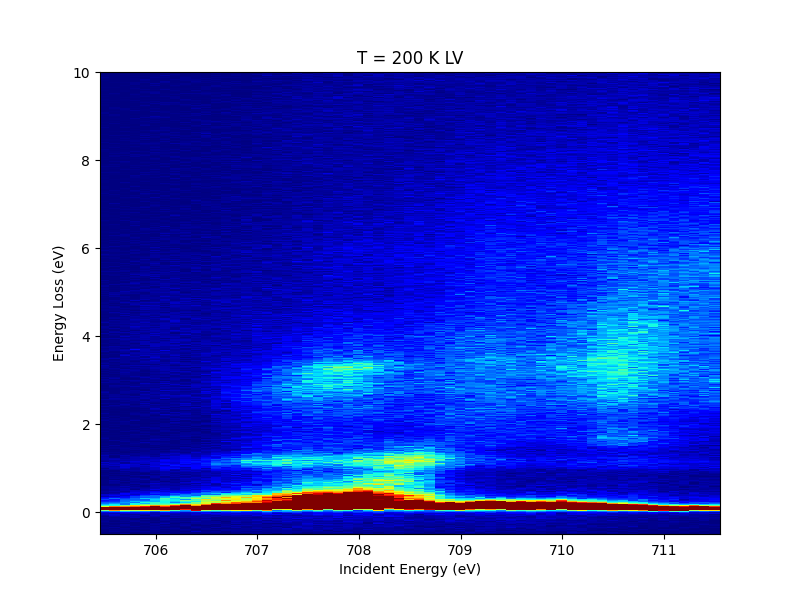

In [11]:
# %%

fig = plt.figure()

scans = [x for x in range(267,328)]

matrixData = np.array([])
matrixEloss = np.array([])
matrixEi = np.array([])

for i,s in enumerate(scans):
    [Eloss,oneData] = CombineData([s])
    [Eloss,oneData] = fixvalue(oneData)
    ei = GetEnergy(s)
    # fitResults=fit_multi_peaks(Eloss,oneData, [-1,1],output=0)
    # zeroshift=fitResults['P1_center']/energyDispersion
    # Eloss = Eloss-fitResults['P1_center']
    # oneData = np.roll(oneData,int(np.around(zeroshift)))
    if i == 0:
        matrixData=oneData
        matrixEloss=Eloss
        matrixEi=Eloss-Eloss+ei
    else:
        matrixData=np.vstack((matrixData,oneData))
        matrixEloss=np.vstack((matrixEloss,Eloss))
        matrixEi=np.vstack((matrixEi,Eloss-Eloss+ei))

plt.pcolor(matrixEi,matrixEloss,matrixData,shading='auto',cmap='jet',vmax=250)
plt.ylim([-0.5,10])
plt.xlabel('Incident Energy (eV)')
plt.ylabel('Energy Loss (eV)')
plt.title('T = 200 K LV')